In [1]:
# import libraries
import torch
import torch.nn as nn
import torch.nn.functional as F

import numpy as np
import matplotlib.pyplot as plt
from IPython import display

from sklearn.model_selection import train_test_split
from torch.utils.data import DataLoader,TensorDataset

# Data

In [2]:
import seaborn as sns
data = sns.load_dataset('iris')
df = torch.tensor(data.drop(columns="species").values).float()
labels = torch.zeros(len(df), dtype=torch.long)
labels[data.species == 'versicolor'] = 1 
labels[data.species == 'virginica'] = 2

In [52]:
x_train, x_test, y_train, y_test = train_test_split(df, labels, train_size=0.7)
tf_train = TensorDataset(x_train, y_train)
tf_test = TensorDataset(x_test, y_test)
train = DataLoader(tf_train, batch_size=54, shuffle=True, drop_last=True)
# Drop last will drop the remaining data that doesn't fit in the batch size
test = DataLoader(tf_test, batch_size=tf_test.tensors[0].shape[0])

In [53]:
tf_train.tensors[0][:10]

tensor([[5.2000, 3.5000, 1.5000, 0.2000],
        [6.3000, 2.8000, 5.1000, 1.5000],
        [4.4000, 3.2000, 1.3000, 0.2000],
        [4.4000, 3.0000, 1.3000, 0.2000],
        [7.2000, 3.2000, 6.0000, 1.8000],
        [4.8000, 3.1000, 1.6000, 0.2000],
        [6.3000, 2.9000, 5.6000, 1.8000],
        [7.6000, 3.0000, 6.6000, 2.1000],
        [4.9000, 3.1000, 1.5000, 0.1000],
        [5.0000, 3.3000, 1.4000, 0.2000]])

In [54]:
tf_train.tensors[1][:10]

tensor([0, 2, 0, 0, 2, 0, 2, 2, 0, 0])

In [55]:
for x,y in train:
    print(x.shape, y.shape)

torch.Size([54, 4]) torch.Size([54])


In [56]:
for x,y in test:
    print(x.shape, y.shape)

torch.Size([45, 4]) torch.Size([45])


In [66]:
def model():
    ann = nn.Sequential(
        nn.Linear(4, 64),
        nn.ReLU(),
        nn.Linear(64, 64),
        nn.ReLU(),
        nn.Linear(64,3)
    )
    lossfn = nn.CrossEntropyLoss()
    optimizer = torch.optim.SGD(ann.parameters(), lr=0.1)
    return ann, lossfn, optimizer

In [67]:
ann, lossfn, optimizer = model()

In [68]:
print(ann)

Sequential(
  (0): Linear(in_features=4, out_features=64, bias=True)
  (1): ReLU()
  (2): Linear(in_features=64, out_features=64, bias=True)
  (3): ReLU()
  (4): Linear(in_features=64, out_features=3, bias=True)
)


In [69]:
numepochs = 2500
def train_model():    
    trainacc = []
    testacc = []
    losses = []
    nweights = 0
    # count the weights of the parameters that are not bias
    for i, j in ann.named_parameters():
        if 'bias' not in i:
            nweights = nweights + j.numel()
    # training
    for i in range(numepochs):
        batchloss = []
        batchacc = []
        # batch training
        for x, y in train:
            yhat = ann(x)
            loss = lossfn(yhat, y)
            # compute gradients
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            batchacc.append(100*torch.mean((torch.argmax(yhat, axis=1)== y).float()).item())
            batchloss.append(loss.item())
        trainacc.append(np.mean(batchacc))
        losses.append(np.mean(batchloss))
        testx, testy = next(iter(test)) 
        pred = torch.argmax(ann(testx), axis=1)
        testacc.append(100*torch.mean((pred==testy).float()).item())
    return trainacc, testacc, losses

In [70]:
trainacc, testacc, losses = train_model()

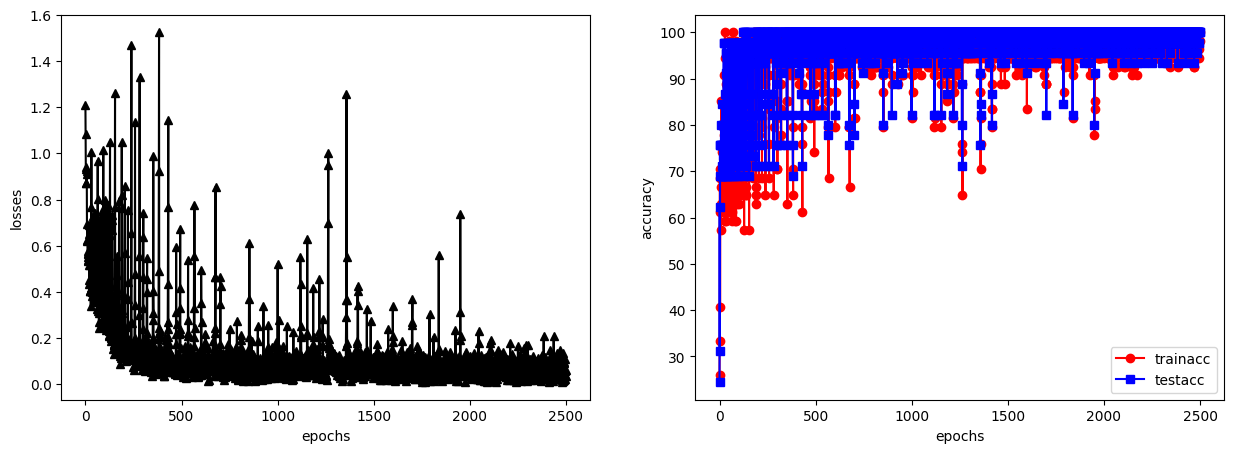

In [71]:
fig, ax = plt.subplots(1, 2, figsize=(15,5))
ax[0].plot(losses,'k^-')
ax[0].set_ylabel("losses")
ax[0].set_xlabel("epochs")
ax[1].plot(trainacc, "ro-")
ax[1].plot(testacc, "bs-")
ax[1].set_ylabel("accuracy")
ax[1].set_xlabel("epochs")
ax[1].legend(['trainacc', 'testacc'])